The purpose of this script is to compute and store the data 
necessary to estimate the relative probability of insertion of L1 elements in various known human tumor suppressor genes (TSGs). The analysis is based on the Snap-Velcro model of Monot et al. 2013. The hg38 
reference genome is used.

In [1]:
#--- Load necessary libraries
library(data.table)
library(BSgenome.Hsapiens.UCSC.hg38)
library(GenomicRanges)
library(GenomicFeatures)
library(plyr)
library(mixtools)
options(warn=1) # print any warnings
colscheme = c("deeppink","darkgreen","dodgerblue","grey")

Loading required package: BSgenome
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: IRanges

Atta

## Check for ./tsg_annotation.rda

In [25]:
if(file.exists("./tsg_annotation.rda")) {
    cat("TSG annotation data file exists, skip to Analysis\n")
} else {
    cat("TSG annotation must be created")
}

TSG annotation data file exists, skip to Analysis


## If not found, create it with the following code, else skip to Analysis

A tab-delimited file is read from the web to a table. The file is made available by the TSGene 2.0 database project and contains data on 983 human tumor suppressor genes which are down-regulated in tumor samples versus normal tissue.

In [2]:
tsg_table <- fread("https://bioinfo.uth.edu/TSGene/All_down_exp_TSGs_pan-cancer.txt")
cat("Sample:")
head(tsg_table)

Sample:

GeneID,GeneName,NumberOfCancers,CancerTypes
9590,AKAP12,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
8854,ALDH1A2,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
84417,C2orf40,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
8434,RECK,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
8031,NCOA4,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
79633,FAT4,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"


A GFF3 file for hg38, which is stored locally, is called, and the entries describing genes are read into a table.

In [3]:
system(paste0("grep ID=gene ../Data/humangenome/Homo_sapiens.GRCh38.89.gff3 > tmp"))
geneann <- fread("tmp") # extract all lines from .gff3 describing genes into a table
system("rm tmp")
cat("Gene list from hg38 .gff3 file")
names(geneann) <- c('chrom','source','type','start','end','score','strand','phase','attributes')
head(geneann)

Gene list from hg38 .gff3 file

chrom,source,type,start,end,score,strand,phase,attributes
1,havana,gene,11869,14409,.,+,.,ID=gene:ENSG00000223972;Name=DDX11L1;biotype=transcribed_unprocessed_pseudogene;description=DEAD/H-box helicase 11 like 1 [Source:HGNC Symbol%3BAcc:HGNC:37102];gene_id=ENSG00000223972;logic_name=havana;version=5
1,havana,gene,14404,29570,.,-,.,ID=gene:ENSG00000227232;Name=WASH7P;biotype=unprocessed_pseudogene;description=WAS protein family homolog 7 pseudogene [Source:HGNC Symbol%3BAcc:HGNC:38034];gene_id=ENSG00000227232;logic_name=havana;version=5
1,mirbase,miRNA_gene,17369,17436,.,-,.,ID=gene:ENSG00000278267;Name=MIR6859-1;biotype=miRNA;description=microRNA 6859-1 [Source:HGNC Symbol%3BAcc:HGNC:50039];gene_id=ENSG00000278267;logic_name=ncrna;version=1
1,havana,lincRNA_gene,29554,31109,.,+,.,ID=gene:ENSG00000243485;Name=MIR1302-2HG;biotype=lincRNA;description=MIR1302-2 host gene [Source:HGNC Symbol%3BAcc:HGNC:52482];gene_id=ENSG00000243485;logic_name=havana;version=5
1,mirbase,miRNA_gene,30366,30503,.,+,.,ID=gene:ENSG00000284332;Name=MIR1302-2;biotype=miRNA;description=microRNA 1302-2 [Source:HGNC Symbol%3BAcc:HGNC:35294];gene_id=ENSG00000284332;logic_name=ncrna;version=1
1,havana,lincRNA_gene,34554,36081,.,-,.,ID=gene:ENSG00000237613;Name=FAM138A;biotype=lincRNA;description=family with sequence similarity 138 member A [Source:HGNC Symbol%3BAcc:HGNC:32334];gene_id=ENSG00000237613;logic_name=havana;version=2


Next, we filter through the gene annotations, storing those describing TSGs from the TSGene 2.0 list.

In [4]:
j=1;
tsg_inds<-rep(0,nrow(tsg_table)) # allocate memory for array of TSG indices in the list of genes
for (i in tsg_table$GeneName){
        tmp <- grep(paste0("Name=",i,";"),geneann$attributes) # search for "Name=<gene name>" in the attributes column of the .gff3
        if (length(tmp)==0){ # if it was not found, place a NA for index of the current TSG
                tsg_inds[j]=NA;
        } else { # if found, store its index in the list
                tsg_inds[j] <- tmp
        }
        j<-j+1 # increment tsg_inds array counter
        # print(grep(paste0("Name=",i,";"),geneann$V9)) # print to screen the index of the current TSG (not necessary)
}
tsgann <- geneann[tsg_inds] # extract rows of the geneann table associated with TSGs
tsgann <- tsgann[,c("chrom","start","end")] # extract columns describing genomic ranges (chrom name, start, end)

Warning message in tsg_inds[j] <- tmp:
“number of items to replace is not a multiple of replacement length”Warning message in tsg_inds[j] <- tmp:
“number of items to replace is not a multiple of replacement length”

In [7]:
tsgann$tsg_name <- tsg_table$GeneName # add gene names to the table
tsgann=tsgann[which(!is.na(tsgann$chrom))] # remove entries from the table which were not found in the GFF3
tsg_len = tsgann$end- tsgann$start
tsgann$length <- tsg_len # add a column for gene length
tsgann = tsgann[order(-tsg_len)] # order the rows of the table by gene length (longest gene in top entry)
head(tsgann)
cat(paste0(nrow(tsgann),"/",nrow(tsg_table)," TSGs from the database were located in hg38.\n"))

chrom,start,end,tsg_name,length
7,146116002,148420998,CNTNAP2,2304996
9,8314246,10612723,PTPRD,2298477
X,31097677,33339441,DMD,2241764
8,2935353,4994972,CSMD1,2059619
2,140231423,142131701,LRP1B,1900278
10,65912518,67696169,CTNNA3,1783651


971/983 TSGs from the database were located in hg38.


Get the gene sequences. Notice that they are ordered by length.

In [8]:
gr <- GRanges(paste0("chr",tsgann$chrom),IRanges(tsgann$start,tsgann$end))
tsgs <- getSeq(Hsapiens,gr)
tsgs

  A DNAStringSet instance of length 971
        width seq
  [1] 2304997 GCTGATGGACCCCGGCCGGTCGGCTCAGTCTC...AAAATTCAAAGTAGTTTTAATTATCCTAAAA
  [2] 2298478 TGCATAACACTGACATTTTTATTAGAATTCAT...CTCTCCCCGCCGAGGCTGGCTGGCGGCGCCG
  [3] 2241765 GATGGTGGAGGTGGAGAATTTTATTTAGGGAT...TATTTGAATTCCAACAGCTCCCCTTTCGCAT
  [4] 2059620 TAGAAATCTAAAATTAAATATTTAATTAGAAC...AGAGGGGACCGAGGCTGGGCACGGCGCAGTC
  [5] 1900279 TTAAATATGTAGAATTTCATTTAAATAAGTCA...TGGCAGCGTTTTTCTCTGGGGTTCTGTCTTT
  ...     ... ...
[967]    1320 GCAGGAGAGACACAGAGTCCGGCATTGGTCCC...TCCTCTCAATAAAGTTCCCCTGTGACACTCC
[968]    1299 AAGCAGCATTCCCAAGTCCCGCTTTCACCCGC...TGTGAATGATAATAAAACAGCTTTGACTTGA
[969]    1183 GCAGATGACACGATTCATTTATTCATTCAAAG...CTCGTGGCCCCGGCGCGGCCTTTATAGCTGC
[970]    1048 TTGATTTATTTTGTTTATTTAAAATCATAAGG...CACCGAGGAACTGCGGTGCGGAAACTAAGAT
[971]     969 GCGGAGTCTCCAACTGGGAGAGCTGCAGCTGC...GCATTTTGAAATAAAAAAACTTTTTATACCA

Loop over the list of TSGs. For each, count the number of endonuclease sites for each Snap-Velcro category. This is done using the locally stored function 'mapSeq_SV.r'. The counts are appended to the TSG annotation table as columns.

In [9]:
source("../dev/mapSeq_SV.r")
tsg_counts <-  array(0,dim=c(nrow(tsgann),4)) # Allocate memory
for (i in 1:nrow(tsgann)){
    tmp <- mapSeq_SV(tsgs[[i]])
    tsg_counts[i,]=c(length(which(!is.na(tmp$ict))),length(which(!is.na(tmp$icl))),length(which(!is.na(tmp$iot))),length(which(!is.na(tmp$iol))))
}
tsgann <- cbind(tsgann,tsg_counts)
rownames(tsg_counts) <- tsgann$tsg_name

In [10]:
names(tsgann)[6:9]=c("CT","CL","OT","OL")
head(tsgann)

chrom,start,end,tsg_name,length,CT,CL,OT,OL
7,146116002,148420998,CNTNAP2,2304996,27991,49689,125627,321834
9,8314246,10612723,PTPRD,2298477,28352,53586,135691,341830
X,31097677,33339441,DMD,2241764,26482,50536,122352,324849
8,2935353,4994972,CSMD1,2059619,23141,43068,105319,279690
2,140231423,142131701,LRP1B,1900278,24179,45982,116120,287206
10,65912518,67696169,CTNNA3,1783651,21677,41250,105436,259527


In [26]:
save(tsgann,tsg_counts,file="./tsg_annotation.rda")

Next, we plot the total number of endonuclease sites for the 100 longest TSGs.

## Analysis 1 - All endonuclease sites are considered

In [6]:
load("./tsg_annotation.rda")

tsg_EN_den = rowSums(tsg_counts)/tsgann$length # calculate density of EN sites of each TSG
rownames(tsg_counts) <- tsgann$tsg_name

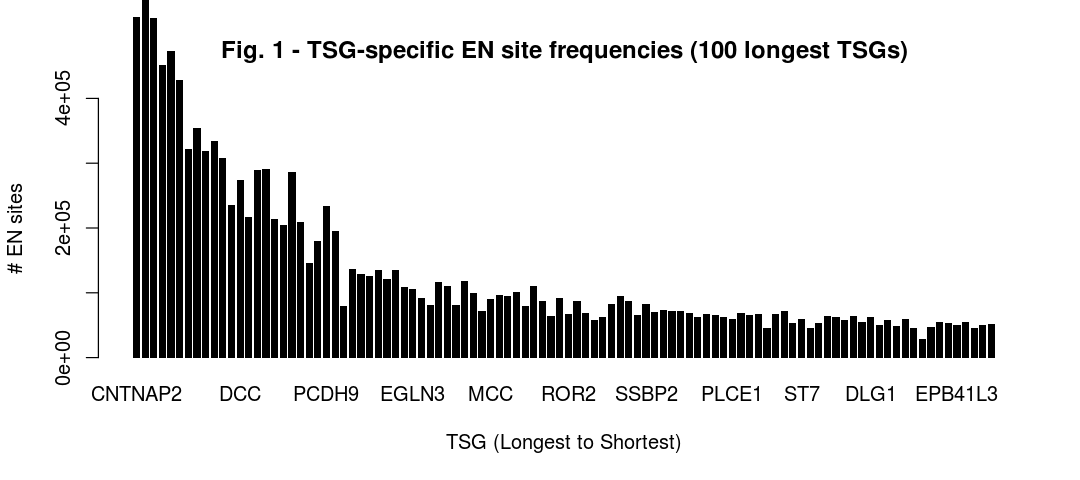

In [37]:
barplot(t(tsg_counts[1:100,1:4]),col=c("black","black","black","black"),ylab="# EN sites",xlab="TSG (Longest to Shortest)",border=NA,beside=FALSE,ylim=c(0,400000))
title("Fig. 1 - TSG-specific EN site frequencies (100 longest TSGs)")
options(repr.plot.width=9, repr.plot.height=4)

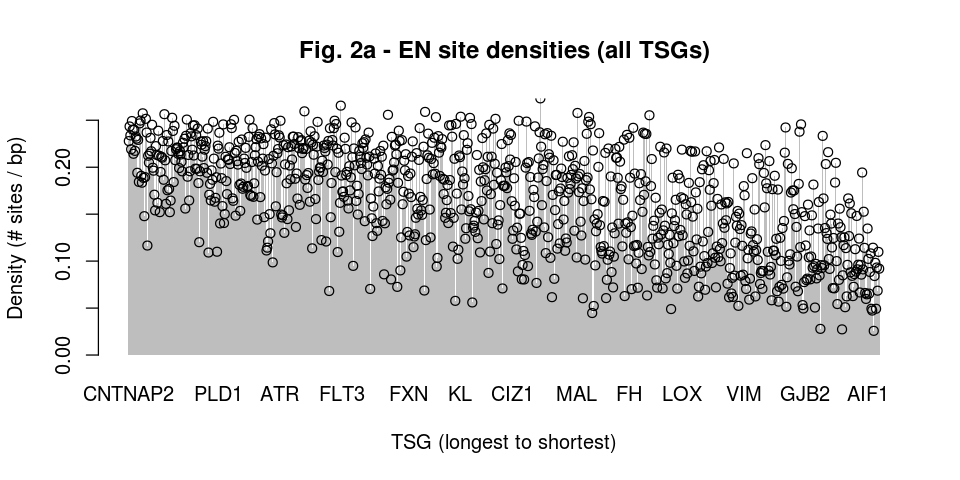

In [15]:
bar <- barplot(tsg_EN_den,ylab="Density (# sites / bp)",xlab="TSG (longest to shortest)",col="grey",border=NA,space=0)
title("Fig. 2a - EN site densities (all TSGs)")
points(x=bar,tsg_EN_den)
options(repr.plot.width=8, repr.plot.height=4)

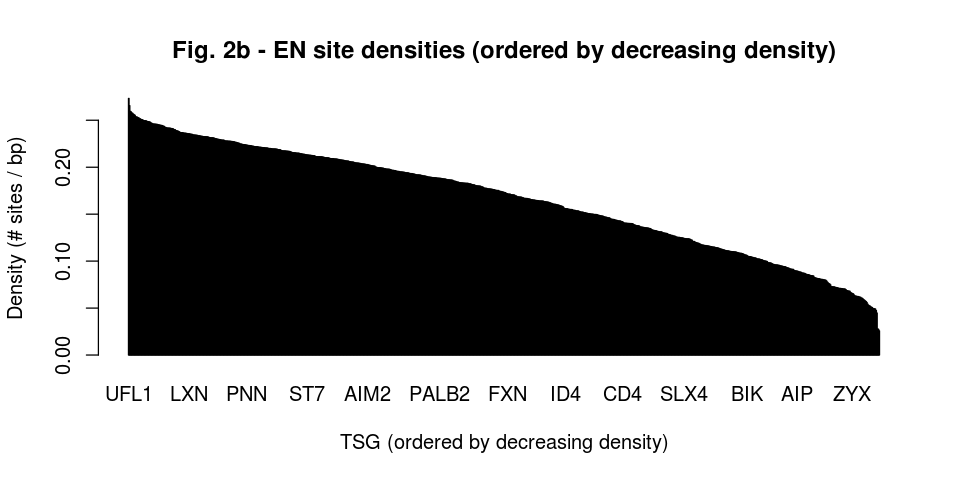

In [17]:
barplot(tsg_EN_den[order(-tsg_EN_den)],ylab="Density (# sites / bp)",xlab="TSG (ordered by decreasing density)",col="black")
title("Fig. 2b - EN site densities (ordered by decreasing density)")
options(repr.plot.width=8, repr.plot.height=4)

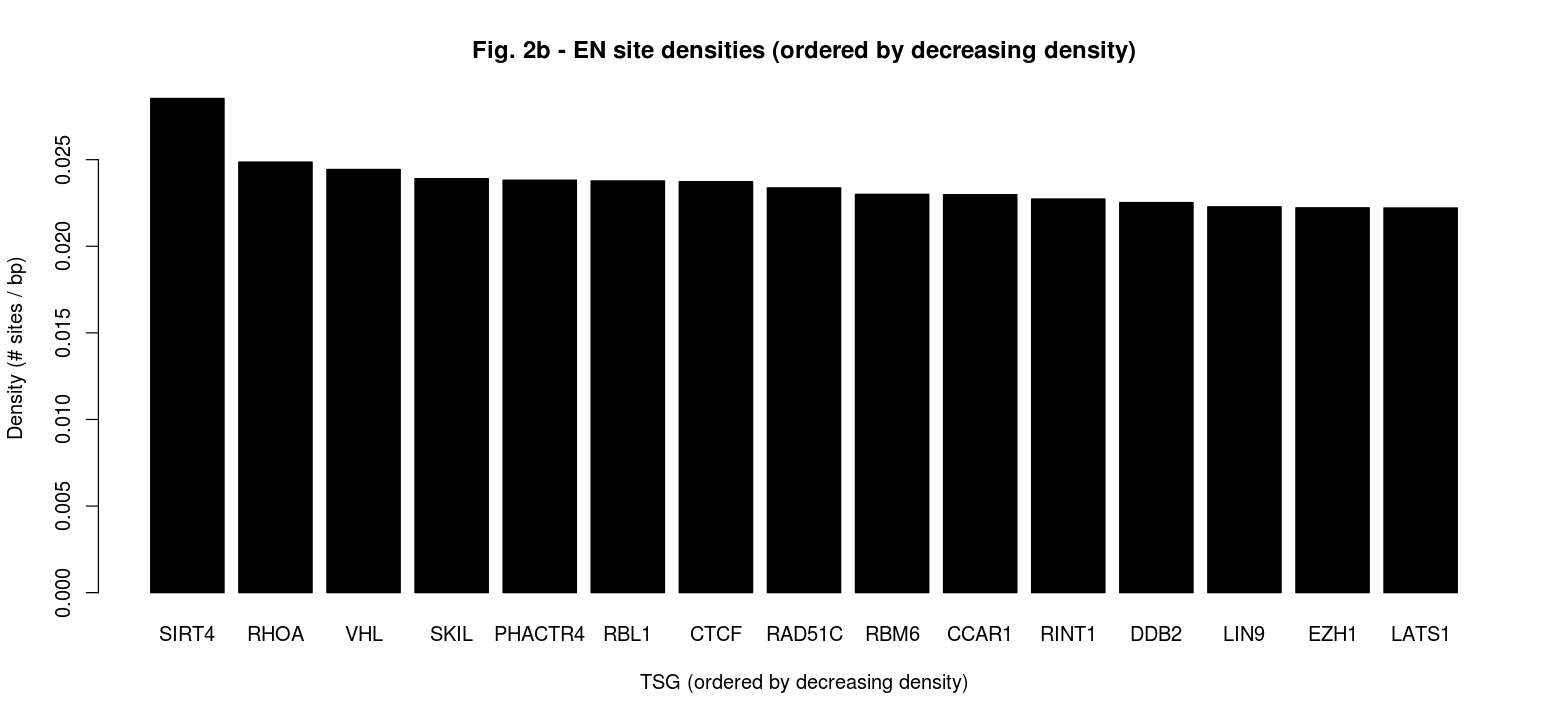

In [62]:
tmp <-tsg_EN_den[order(-tsg_EN_den)]

barplot(tmp[1:15],ylab="Density (# sites / bp)",xlab="TSG (ordered by decreasing density)",col="black")
title("Fig. 2b - EN site densities (ordered by decreasing density)")
options(repr.plot.width=13, repr.plot.height=6)

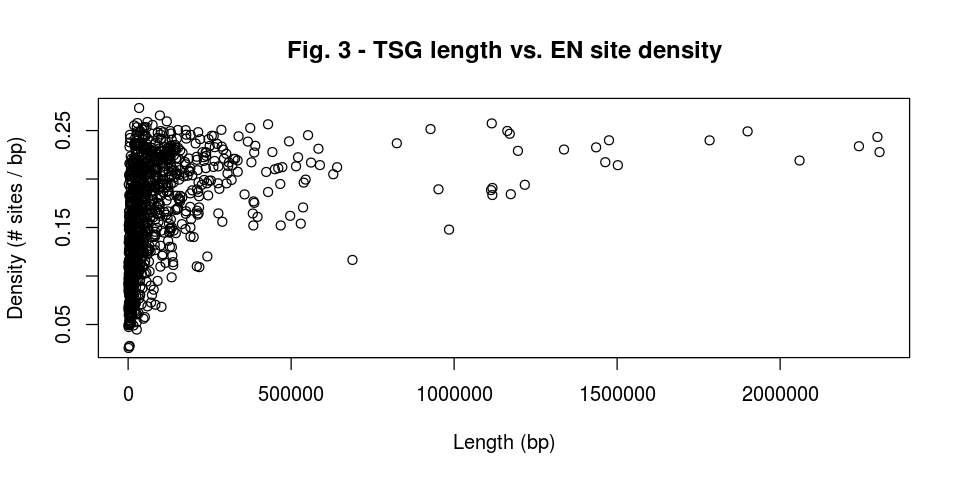

In [20]:
plot(tsgann$length,tsg_EN_den,ylab="Density (# sites / bp)",xlab="Length (bp)")
title("Fig. 3 - TSG length vs. EN site density")
options(repr.plot.width=8, repr.plot.height=4)

Several TSGs are much longer than the others, with a high density of EN sites (upper right corner). We print six TSGs with the highest number of sites below.

In [21]:
nsites <- rowSums(tsg_counts)
tmp <- nsites[1:6]
tmp[order(-tmp)]

PTPRD CNTNAP2     DMD   LRP1B   CSMD1  CTNNA3 
 559459  525141  524219  473487  451218  427890

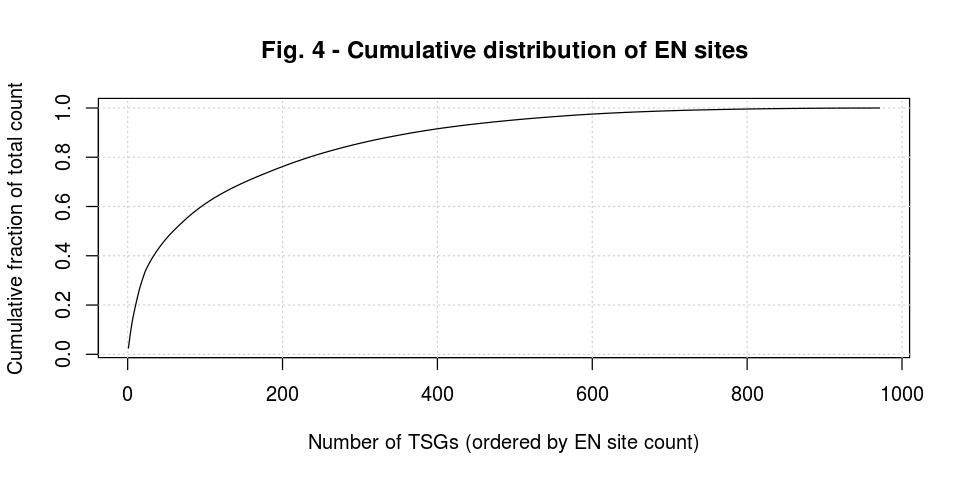

In [24]:
fracOfTotalSites <- nsites/sum(nsites)
fracOfTotalSites <- fracOfTotalSites[order(-fracOfTotalSites)]
cumuSum <- cumsum(fracOfTotalSites)
options(repr.plot.width=8, repr.plot.height=4)
plot(cumuSum,type="n",xlab="Number of TSGs (ordered by EN site count)",ylab="Cumulative fraction of total count")
grid()
lines(cumuSum)
title("Fig. 4 - Cumulative distribution of EN sites")

## Analysis 2 - Only 'closed-tight' sites considered

In [11]:
load("./tsg_annotation.rda")

tsg_EN_den = tsg_counts[,1]/tsgann$length # calculate density of closed-tight sites of each TSG
rownames(tsg_counts) <- tsgann$tsg_name

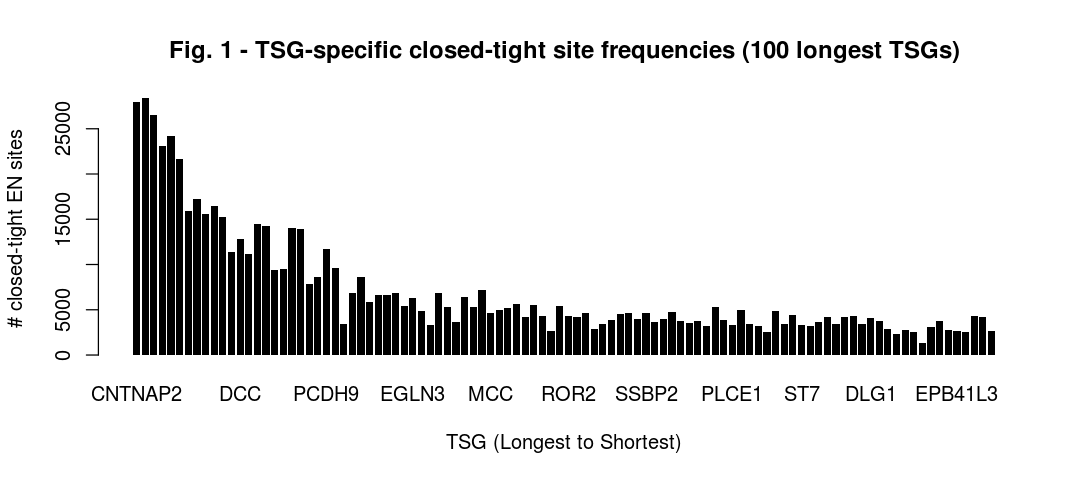

In [14]:
barplot(t(tsg_counts[1:100,1]),col="black",ylab="# closed-tight EN sites",xlab="TSG (Longest to Shortest)",border=NA)
title("Fig. 1 - TSG-specific closed-tight site frequencies (100 longest TSGs)")
options(repr.plot.width=9, repr.plot.height=4)

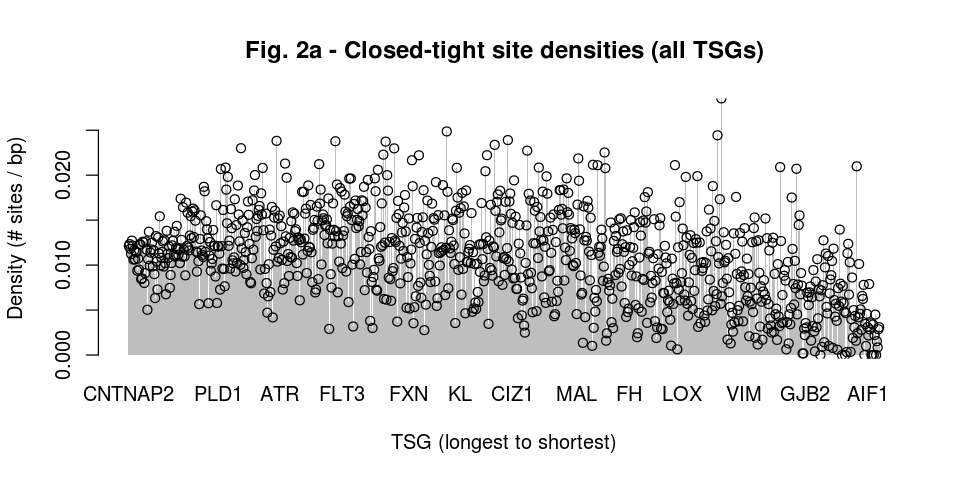

In [27]:
bar <- barplot(tsg_EN_den,ylab="Density (# sites / bp)",xlab="TSG (longest to shortest)",col="grey",border=NA,space=0)
title("Fig. 2a - Closed-tight site densities (all TSGs)")
points(x=bar,tsg_EN_den)
options(repr.plot.width=8, repr.plot.height=4)

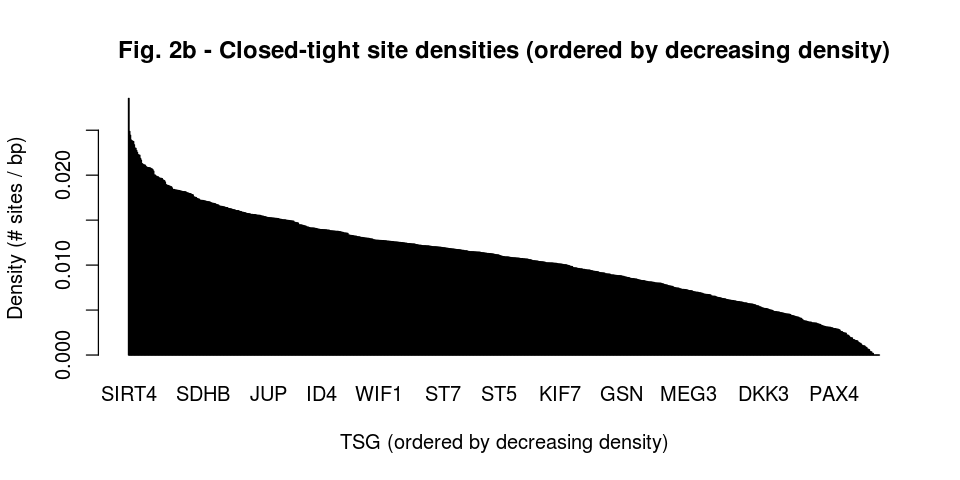

In [25]:
barplot(tsg_EN_den[order(-tsg_EN_den)],ylab="Density (# sites / bp)",xlab="TSG (ordered by decreasing density)",col="black")
title("Fig. 2b - Closed-tight site densities (ordered by decreasing density)")
options(repr.plot.width=8, repr.plot.height=4)

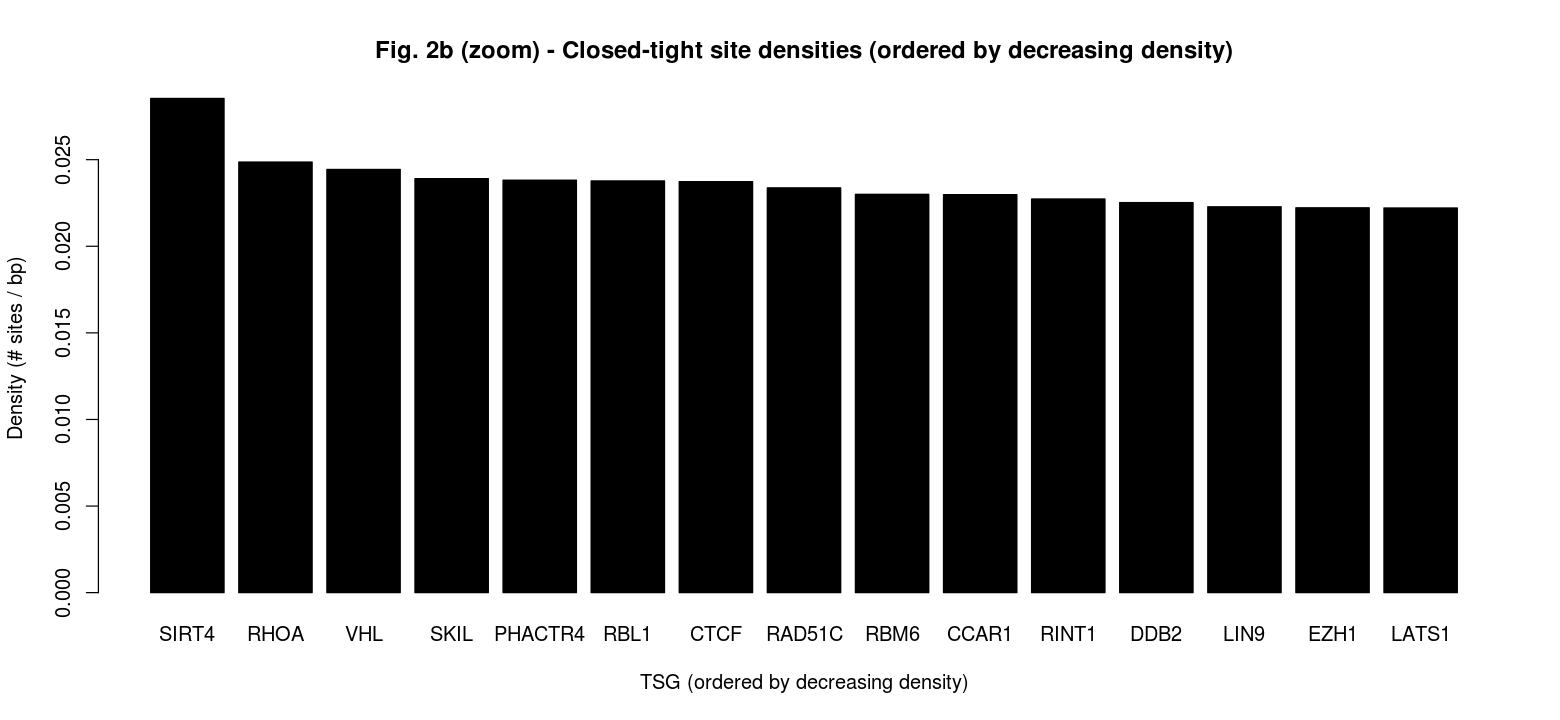

In [60]:
tmp <- tsg_EN_den[order(-tsg_EN_den)]

barplot(tmp[1:15],ylab="Density (# sites / bp)",xlab="TSG (ordered by decreasing density)",col="black")
title("Fig. 2b (zoom) - Closed-tight site densities (ordered by decreasing density)")
options(repr.plot.width=13, repr.plot.height=6)

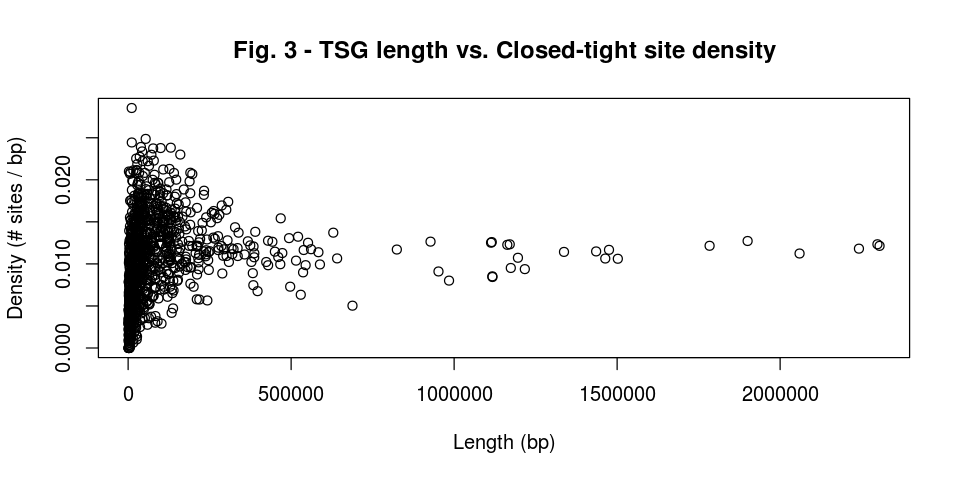

In [28]:
plot(tsgann$length,tsg_EN_den,ylab="Density (# sites / bp)",xlab="Length (bp)")
title("Fig. 3 - TSG length vs. Closed-tight site density")
options(repr.plot.width=10, repr.plot.height=4)

In [30]:
nsites <- tsg_counts[,1]
tmp <- nsites[1:6]
tmp[order(-tmp)]

PTPRD CNTNAP2     DMD   LRP1B   CSMD1  CTNNA3 
  28352   27991   26482   24179   23141   21677

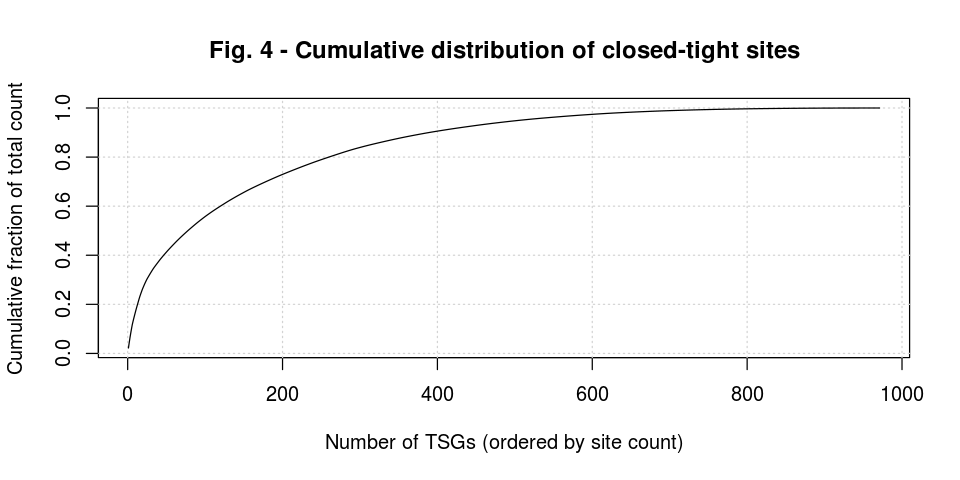

In [34]:
fracOfTotalSites <- nsites/sum(nsites)
fracOfTotalSites <- fracOfTotalSites[order(-fracOfTotalSites)]
cumuSum <- cumsum(fracOfTotalSites)
options(repr.plot.width=8, repr.plot.height=4)
plot(cumuSum,type="n",xlab="Number of TSGs (ordered by site count)",ylab="Cumulative fraction of total count")
grid()
lines(cumuSum)
title("Fig. 4 - Cumulative distribution of closed-tight sites")

# Analysis below is still in progress


In the analysis below, we map the density of endonuclease sites over the sequence of the PTPRD gene using a moving average method.

First, we compute the coordinates of each EN site in the gene, and its Snap-Velcro state.

In [186]:
PTPRD <- tsgs[[2]]
tmp<- mapSeq_SV(PTPRD)

In [187]:
en_movingav <- function(sequence) {
    halfWin <- 100000
    step <- 1000
    en_signal <- matrix(nrow=floor(length(sequence)/step),ncol=4)
    x_vals <- array(0,dim=c(1,floor(length(sequence)/step)))
    i<-halfWin+1
    j<-1
    while (i+halfWin < length(sequence)) {
        tmp_s   <- inrange(tmp$insites[tmp$ict[which(!is.na(tmp$ict[,1])),1],1],i-halfWin,i+halfWin)
        tmp_ns  <- inrange(tmp$insites[tmp$ict[which(!is.na(tmp$ict[,2])),2],2],i-halfWin,i+halfWin)
        en_signal[j,1]<-length(which(tmp_s==TRUE)) + length(which(tmp_ns==TRUE))
        tmp_s   <- inrange(tmp$insites[tmp$icl[which(!is.na(tmp$icl[,1])),1],1],i-halfWin,i+halfWin)
        tmp_ns  <- inrange(tmp$insites[tmp$icl[which(!is.na(tmp$icl[,2])),2],2],i-halfWin,i+halfWin)
        en_signal[j,2]<-length(which(tmp_s==TRUE)) + length(which(tmp_ns==TRUE))
        tmp_s   <- inrange(tmp$insites[tmp$iot[which(!is.na(tmp$iot[,1])),1],1],i-halfWin,i+halfWin)
        tmp_ns  <- inrange(tmp$insites[tmp$iot[which(!is.na(tmp$iot[,2])),2],2],i-halfWin,i+halfWin)
        en_signal[j,3]<-length(which(tmp_s==TRUE)) + length(which(tmp_ns==TRUE))
        tmp_s   <- inrange(tmp$insites[tmp$iol[which(!is.na(tmp$iol[,1])),1],1],i-halfWin,i+halfWin)
        tmp_ns  <- inrange(tmp$insites[tmp$iol[which(!is.na(tmp$iol[,2])),2],2],i-halfWin,i+halfWin)
        en_signal[j,4]<-length(which(tmp_s==TRUE)) + length(which(tmp_ns==TRUE))
        x_vals[j] = i
        i <- i+step
        j<-j+1
    }
    return(list(en_signal,x_vals))
}
ptm <- proc.time()
enSig <- en_movingav(PTPRD)
proc.time() - ptm

In [ ]:
options(repr.plot.width=10, repr.plot.height=4)
matplot(t(enSig[[2]]),enSig[[1]][,1],type="n",xlab="Gene Coordinates",ylab="# CT EN sites / 100000 bp")
lines(enSig[[2]],enSig[[1]][,1])

We will use the GenomicFeatures library to create a data structure from the locally stored hg38 GFF3 file.

In [ ]:
txdb <- makeTxDbFromGFF("../Data/humangenome/Homo_sapiens.GRCh38.89.gff3")
exonsByGene <- exonsBy(txdb,by="gene")

In [ ]:
exonsByGene$PTPRD
ones = array(1,dim=c(length(PTPRD),1))
for (i in 1:length(exonsByGene$PTPRD)) {
    ones[start(exonsByGene$PTPRD)[i]:end(exonsByGene$PTPRD)[i]]=mean(enSig[[1]][,1])
}
plot(ones)